In [1]:
from sample_size_experiment import *

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from IPython.display import display

from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

## Iris Dataset (Test Functionality)

Run each model on a small sample dataset

In [3]:
from random import sample

def random_sample(X, y, samples):
    
    ordered_indices = [num for num in range(samples)]
    random_indices = sample(ordered_indices, samples)

    X = X[random_indices]
    y = y[random_indices]

    return X, y

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()

X = np.array(data['data'], dtype=np.float32)
y = np.array(data['target'], dtype=np.float32)

random_forest_classification_errors = []
parametric_dnn_classification_errors = []

for max_sample_size in range(30,X.shape[0],10):
    
    X_scaled, y_scaled = random_sample(X, y, max_sample_size)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=101)

    rf_model = random_forest_classifier_model(X_train = X_train,
                                              y_train = y_train, 
                                              num_trees = 20, 
                                              max_depth = None, 
                                              verbose = 1
                                             )
    rf_predictions = rf_model.predict(X_test)
    rf_error = 1 - accuracy_score(y_test, rf_predictions)

    random_forest_classification_errors.append(rf_error)
    
    y_train=to_categorical(y_train,num_classes=3)
    y_test=to_categorical(y_test,num_classes=3)

    dnn_model = parametric_deep_neural_network(X_train = X_train,
                                               y_train = y_train, 
                                               epochs = 20,
                                               batch_size = 1, 
                                               learning_rate = 0.001,
                                               validation_split = 0.3,
                                               verbose = 1
                                              )

    score = dnn_model.evaluate(X_test, y_test, batch_size=None, verbose=0, sample_weight=None, steps=None,
                    callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                    return_dict=False)

    dnn_error = 1 - score[1]
    parametric_dnn_classification_errors.append(dnn_error)

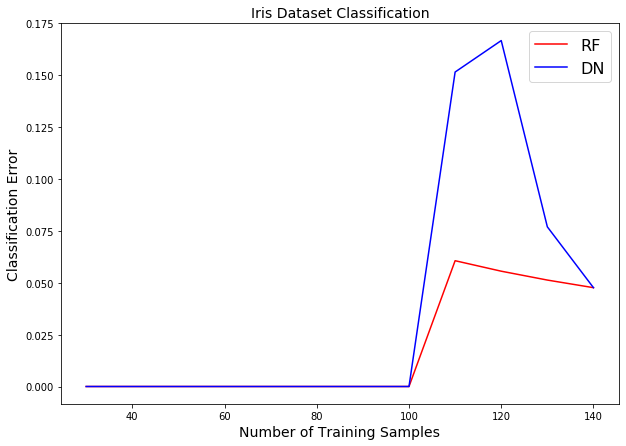

In [12]:
plt.figure(figsize = (10,7))
plt.plot(range(30,X.shape[0],10), random_forest_classification_errors, color= 'r')
plt.plot(range(30,X.shape[0],10), parametric_dnn_classification_errors, color= 'b')
plt.title('Iris Dataset Classification', fontsize=14)
plt.ylabel('Classification Error', fontsize=14)
plt.xlabel('Number of Training Samples', fontsize=14)
plt.legend(['RF', 'DN'], prop={'size': 16})

## Sparse Parity Dataset Creation

In [4]:
X_parity = np.random.uniform(-1,1,[30000,20])

In [5]:
def sparse_parity_labels(X, p_star):
    q = np.zeros(X.shape[0])
    y = np.where(X[:,:3] >= 0, 1, 0)
    return np.sum(y, axis = 1) % 2

In [6]:
y_parity = sparse_parity_labels(X_parity, 3)

In [7]:
np.array(X_parity, dtype=np.float32).shape

(30000, 20)

In [ ]:
from sklearn.model_selection import train_test_split

X = np.array(X_parity, dtype=np.float32)
y = np.array(y_parity, dtype=np.float32)

iterations = 5

sample_sizes = [500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 30000]

rf_evolution = np.zeros((len(sample_sizes), iterations))
dnn_evolution = np.zeros((len(sample_sizes), iterations))

# sample_sizes = [500, 1000, 2000]

for iteration in range(iterations):
    print(iteration)
    
    for sample_size_index, max_sample_size in enumerate(sample_sizes):
        print(max_sample_size)

        X_scaled, y_scaled = random_sample(X, y, max_sample_size)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=101)

        rf_model = random_forest_classifier_model(X_train = X_train,
                                                  y_train = y_train, 
                                                  num_trees = 64, 
                                                  max_depth = 3, 
                                                  verbose = 1
                                                 )
        rf_predictions = rf_model.predict(X_test)
        rf_error = 1 - accuracy_score(y_test, rf_predictions)

        rf_evolution[sample_size_index][iteration] = rf_error

    #     y_train=to_categorical(y_train,num_classes=3)
    #     y_test=to_categorical(y_test,num_classes=3)

        dnn_model = parametric_deep_neural_network(X_train = X_train,
                                                   y_train = y_train, 
                                                   epochs = 10,
                                                   batch_size = 1, 
                                                   learning_rate = 0.001,
                                                   validation_split = 0.3,
                                                   verbose = 1
                                                  )

        score = dnn_model.evaluate(X_test, y_test, batch_size=None, verbose=0, sample_weight=None, steps=None,
                        callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                        return_dict=False)

        dnn_error = 1 - score[1]
        dnn_evolution[sample_size_index][iteration] = dnn_error


In [9]:
# fig = plt.figure(figsize = (10,7))
# ax = plt.subplot(111)

# ax.plot(sample_sizes, random_forest_classification_errors, color= 'r')
# ax.plot(sample_sizes, parametric_dnn_classification_errors, color= 'b')

# plt.title('Sparse Parity', fontsize=14)
# plt.ylabel('Classification Error', fontsize=14)
# plt.xlabel('Number of Training Samples', fontsize=14)
# plt.legend(['RF', 'DN'], prop={'size': 16})

# fig.savefig('sparse_parity_1.png')

%store dnn_evolution
%store rf_evolution

Stored 'dnn_evolution' (ndarray)
Stored 'rf_evolution' (ndarray)


In [10]:
# dnn_evolution = parametric_dnn_classification_errors[:10,:]
# rf_evolution = random_forest_classification_errors[:10,:]

dnn_evolution_mean = np.mean(dnn_evolution, axis = 1)
rf_evolution_mean = np.mean(rf_evolution, axis = 1)

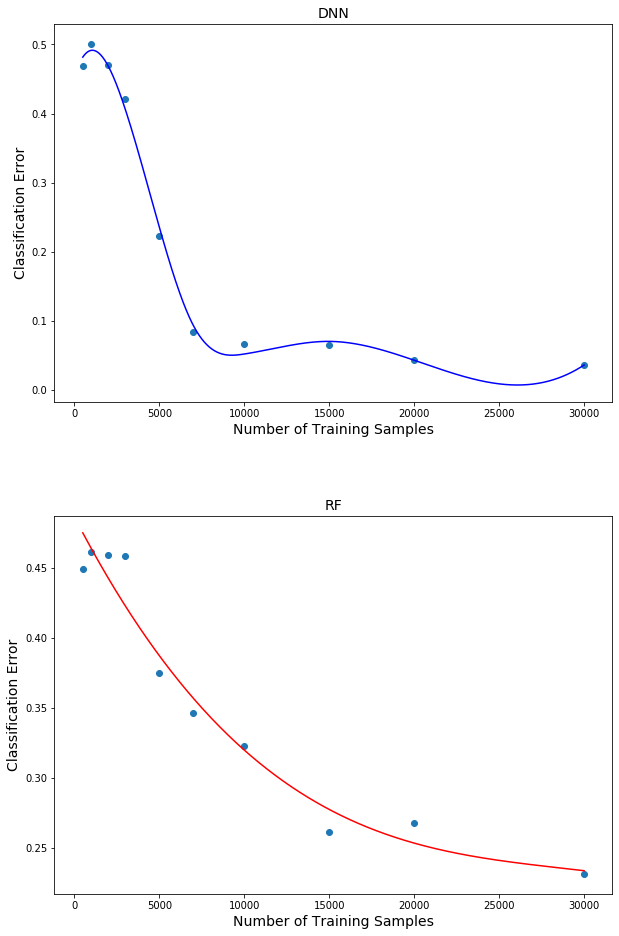

In [45]:
# Fit 1D curve using B-spline representation

from scipy.interpolate import splev, splrep

X_spline = np.asarray(sample_sizes)
y_spline_dnn = dnn_evolution_mean
y_spline_rf = rf_evolution_mean

x2 = np.linspace(500,30000,1000)

spl_dnn = splrep(X_spline,y_spline_dnn, k=3, s=0.001)
y2_dnn = splev(x2, spl_dnn)

spl_rf = splrep(X_spline,y_spline_rf, k=3, s=0.01)
y2_rf = splev(x2, spl_rf)

fig = plt.figure(figsize = (10,16))

ax = plt.subplot(211)
ax.plot(x2, y2_dnn, 'b')
ax.scatter(X_spline, y_spline_dnn) 
plt.title('DNN', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)

ax = plt.subplot(212)
ax.plot(x2, y2_rf, 'r')
ax.scatter(X_spline, y_spline_rf) 
plt.title('RF', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

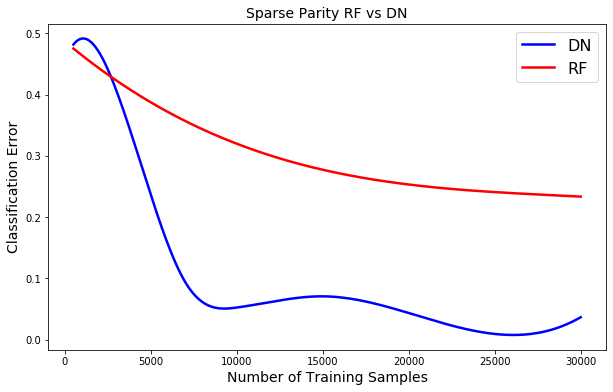

In [46]:
fig = plt.figure(figsize = (10,6))
ax = plt.subplot(111)

ax.plot(x2, y2_dnn, 'b', linewidth = 2.5)
ax.plot(x2, y2_rf, 'r', linewidth = 2.5)

plt.title('Sparse Parity RF vs DN', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

fig.savefig('sparse_parity_3.png')